In [ ]:
!conda install matplotlib

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import h5py

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


# Loading the data

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

There are only numerical variables. The data has been transformed using PCA transformation(s) due to confidentiality issues. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction.

In [2]:
#from google.colab import files
#files.upload()
df = pd.read_csv(r"C:\Users\Farz Jamal\Downloads\Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras-master\creditcard.csv")

# Exploration

In [3]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [34]:
df.isnull().sum().sum()

0

No missing value.

Text(0, 0.5, 'Frequency')

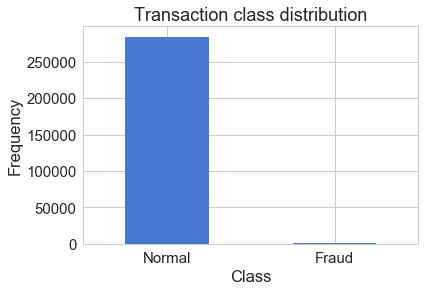

In [13]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar',rot = 0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions: 

In [14]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [15]:
frauds.shape

(492, 31)

In [16]:
normal.shape

(284315, 31)

How different are the amount of money used in different transaction classes?

In [17]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [18]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Let's have a more graphical representation:

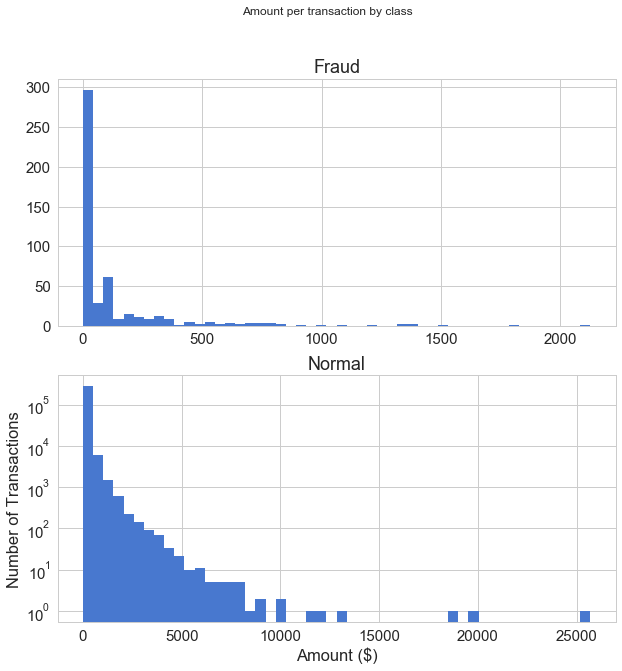

In [23]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize = (10,10))
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

Do fraudulent transactions occur more often during certain time?

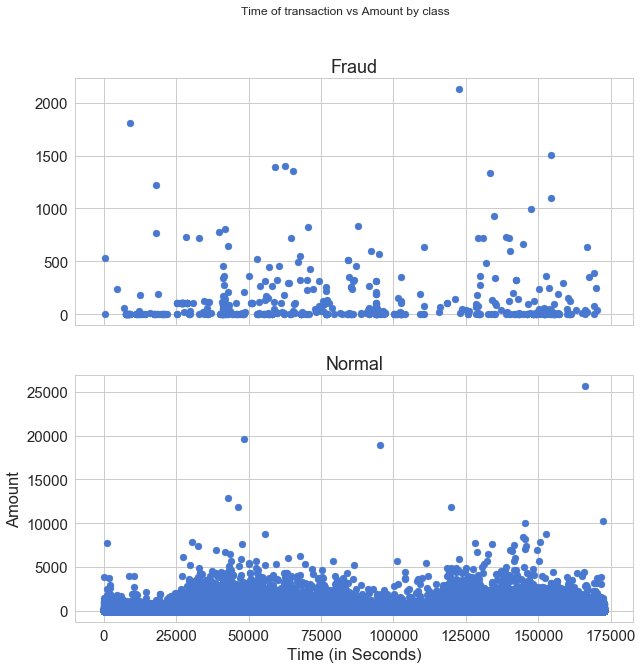

In [27]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (10,10))
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Doesn't seem like the time of transaction really matters.

# Autoencoders

Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. 

More specifically, let’s take a look at Autoencoder Neural Networks. This autoencoder tries to learn to approximate the following identity function:

$$\textstyle f_{W,b}(x) \approx x$$

While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called *undercomplete*.

Here's a visual representation of what an Autoencoder might learn:

![](https://cdn-images-1.medium.com/max/800/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

## Reconstruction error

The parameters of our Autoencoder model is optimized in such way that the **reconstruction error** is minimized. In practice, the traditional squared error is often used:

$$\textstyle L(x,x') = ||\, x - x'||^2$$



# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [28]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. **We will create this situation by training our model on the normal transactions, only.** Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [29]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]    #then, fraud cases will give high reconstruction error.
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [30]:
X_train.shape

(227451, 29)

# Building the model

Our Autoencoder uses 4 fully connected layers with 14, 8, 8 and 29(shape of our input sample) neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L2 regularization will be used during training:

In [31]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [32]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l2(10e-5))(input_layer)  #l2 regularizer
encoder = Dense(int(encoding_dim / 2 + 1), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2 + 1), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)    #linear?

autoencoder = Model(inputs=input_layer, outputs=decoder)  

Instructions for updating:
Colocations handled automatically by placer.


Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [33]:
nb_epoch = 10
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0, 
                               save_best_only=True)   #when best accuracy was given off
tensorboard = TensorBoard(log_dir='F:/models',
                          histogram_freq=0,
                          write_graph=True,       #to visualize
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Instructions for updating:
Use tf.cast instead.
Train on 227451 samples, validate on 56962 samples
Epoch 1/10
227451/227451 [==============================] - 12s 52us/step - loss: 0.7811 - acc: 0.6303 - val_loss: 0.7634 - val_acc: 0.6797
Epoch 2/10
227451/227451 [==============================] - 11s 50us/step - loss: 0.7255 - acc: 0.6825 - val_loss: 0.7485 - val_acc: 0.6934
Epoch 3/10
227451/227451 [==============================] - 11s 50us/step - loss: 0.7146 - acc: 0.6886 - val_loss: 0.7423 - val_acc: 0.6931
Epoch 4/10
227451/227451 [==============================] - 11s 48us/step - loss: 0.7086 - acc: 0.6960 - val_loss: 0.7391 - val_acc: 0.7022
Epoch 5/10
227451/227451 [==============================] - 11s 47us/step - loss: 0.7047 - acc: 0.7044 - val_loss: 0.7361 - val_acc: 0.7094
Epoch 6/10
227451/227451 [==============================] - 11s 50us/step - loss: 0.7023 - acc: 0.7094 - val_loss: 0.7332 - val_acc: 0.7114
Epoch 7/10
227451/227451 [==============================] - 1

In [35]:
from importlib import reload
import keras
reload(keras.models)

<module 'keras.models' from 'G:\\anaconda\\envs\\tensorflow\\lib\\site-packages\\keras\\models.py'>

In [36]:
autoencoder = load_model('model.h5')

# Evaluation

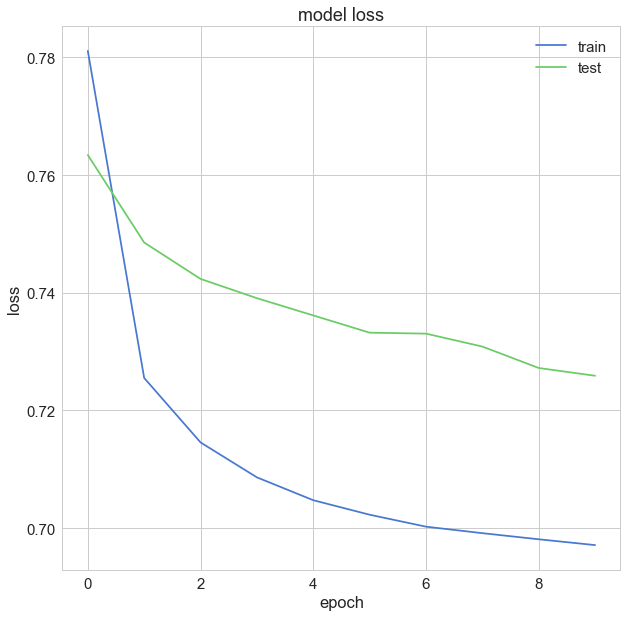

In [42]:
plt.figure(figsize=(10,10))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [43]:
predictions = autoencoder.predict(X_test) #ok

In [44]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [47]:
error_df.head() #error_df.describe()

,reconstruction_error,true_class
43428,77.997093,1
49906,0.752025,0
29474,0.284676,0
276481,0.424703,0
278846,0.151439,0


In [58]:
thresh  = 12 #threshold_for_whether_sample_is_fraud_or_not
print(error_df[(error_df['reconstruction_error'] > thresh) & (error_df['true_class'] == 1)].shape[0])
print(error_df[(error_df['true_class'] == 1)].shape[0])

41
98


## Reconstruction error without fraud

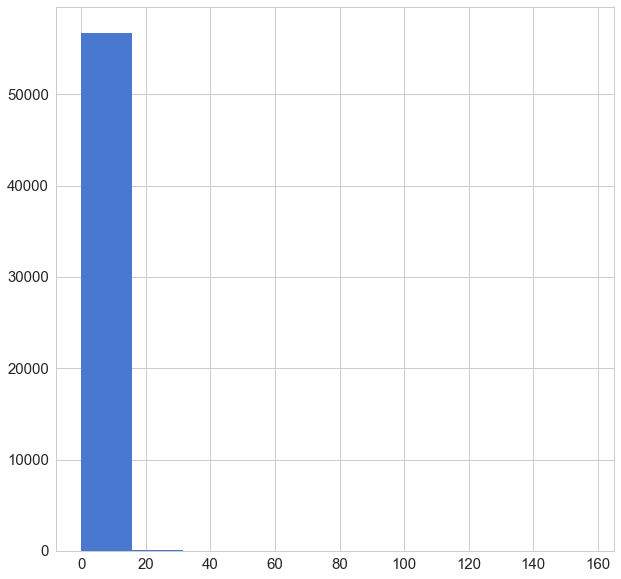

In [60]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0)]   # & (error_df['reconstruction_error'] < 10)
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with fraud

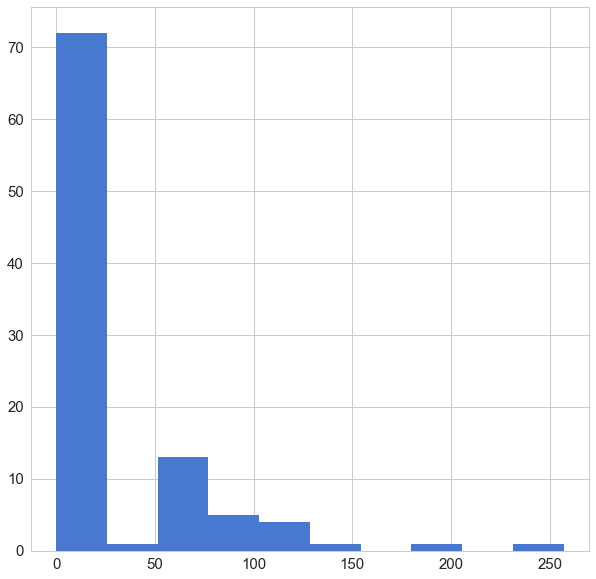

In [62]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [63]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

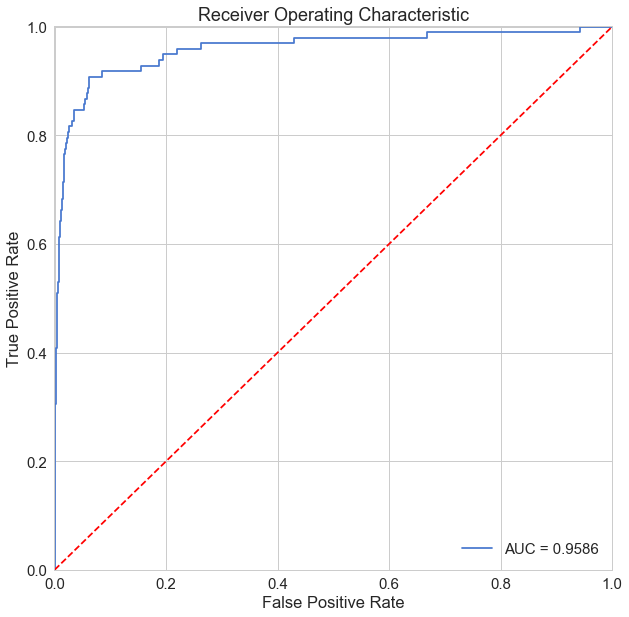

In [65]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)  #roc_curve will evaluate for different thresholds
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind the massive imbalance in our dataset. ROC is not very useful for us. Will have to move on to better things....

## Precision vs Recall

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png" />

Precision and recall are defined as follows:

$$\text{Precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$

$$\text{Recall} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

Let's take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.

Let's return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite - few returned results with very high relevancy. Ideally, you would want high precision and high recall - many results with that are highly relevant.

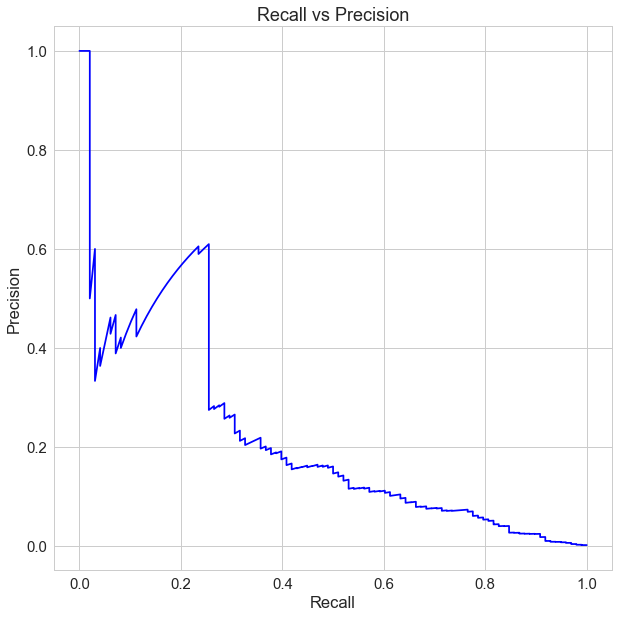

In [68]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.figure(figsize = (10,10))
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

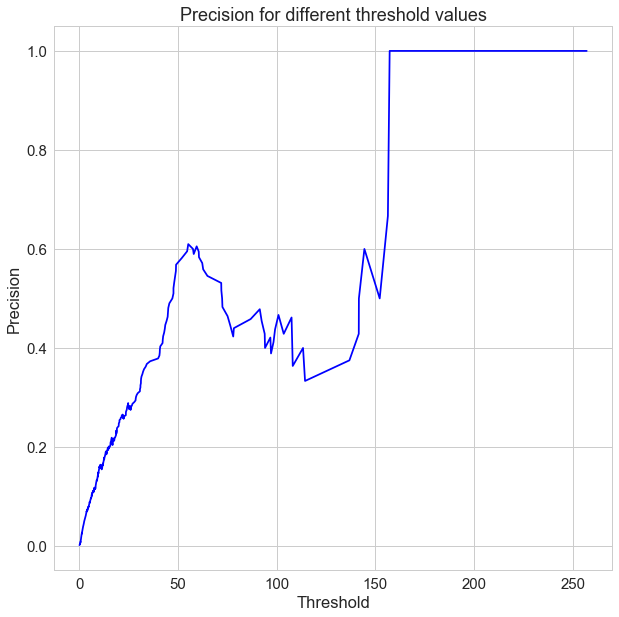

In [70]:
plt.figure(figsize = (10,10))
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

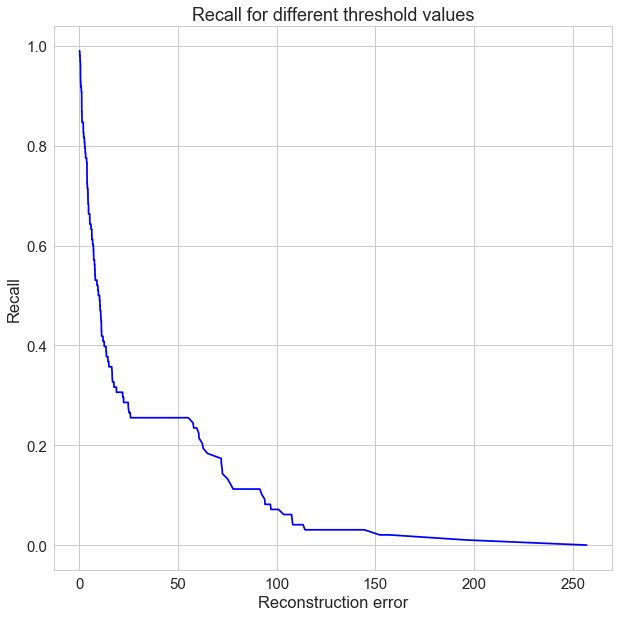

In [72]:
plt.figure(figsize = (10,10))
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

# Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [73]:
threshold = 2.9

And see how well we're dividing the two types of transactions:

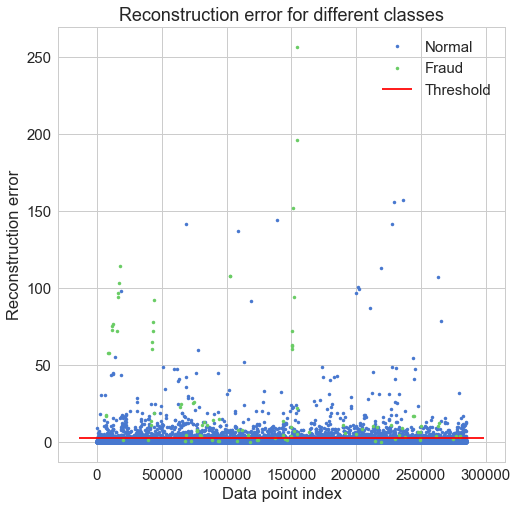

In [79]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize = (8,8))



for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

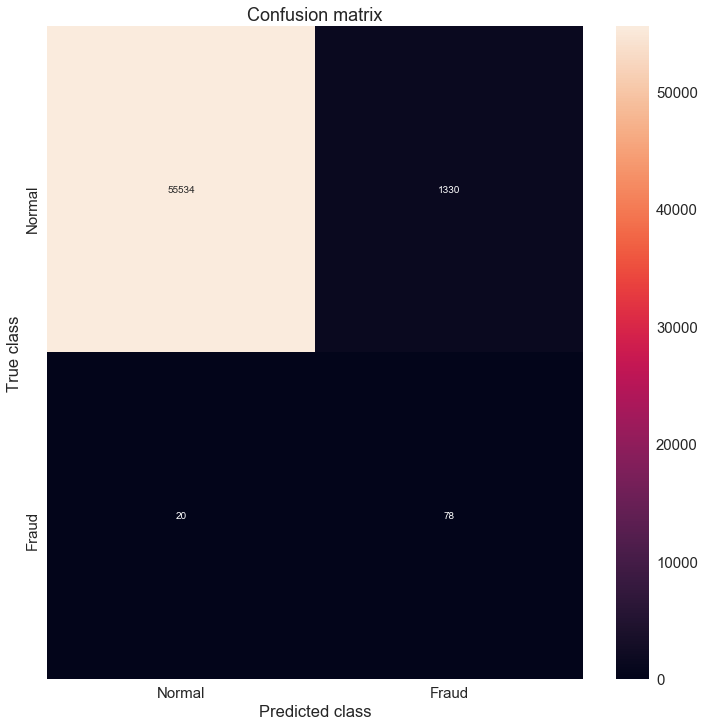

In [82]:
y_pred = [1 if e > threshold  else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Our model seems to catch a lot of the fraudulent cases. But, the number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is.We can increase or decrease the value of the threshold, depending on the problem. 

# Let's Conclude...

We've created a very simple Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. We gave a lot of positive-class examples (normal transactions) to the model and it learned (somewhat) how a positive class sample looks like. Now, when presented with a fraud sample, it naturally had problems in reconstructing it, hence giving off a high reconstruction error.  

Also,Keras gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. 